# SYDE 556/750 --- Assignment 3
**Student ID: 20757197**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_03/syde556_assignment_03.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [1]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
import matplotlib.pyplot as plt

# Fix the numpy random seed for reproducible results
np.random.seed(18945)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Decoding from a population

**a) Tuning curves.** Plot the tuning curves (firing rate of each neuron for different $x$ values between $-2$ and $2$).

Text(0.5, 0, 'x')

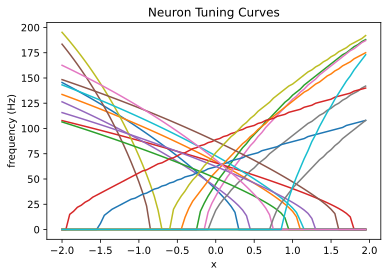

In [2]:
class LIF_neuron:
    def __init__(self, gain, bias, e, tRef=0.002, tRC=0.02):
        self._gain = gain
        self._bias = bias
        self._e = e
        self._tRef = tRef
        self._tRC = tRC
    
    def set_parameters(self, rest_rate, stim_rate):
        tRef = self._tRef
        tRC = self._tRC
        self._bias = 1./(1 - np.exp((rest_rate*tRef - 1)/(rest_rate*tRC)))
        self._gain = (1./(1 - np.exp((stim_rate*tRef - 1.)/(stim_rate*tRC))) - self._bias)
    
    def set_parameters_max (self, x_max, a_max, x_intercepts):
        c = np.exp( (self._tRef - (1. / a_max)) / self._tRC ) 
        k = np.dot(x_intercepts/(np.abs(x_max)), self._e) - 1
        self._gain = (1 - 1. / (1 - c))/k
        self._bias = 1 - (self._gain * np.dot(x_intercepts/(np.abs(x_max)), self._e))
    
    def current_level(self, x):
        x = np.array(x.real, float)
        gain_X = (self._gain)*x
        calculated = np.dot(gain_X, np.array(self._e))
        output = calculated + self._bias
        return output
    
    def neuron_output(self, current):
        f = np.vectorize(self.vectorize_function)
        return f(current)
    
    def vectorize_function(self, j):
        if j <= 1:
            return 0
        return 1./(self._tRef - ( self._tRC*np.log(1 - 1./j) ))
    
    def volt_level(self, x, step, init_cond=0):
        spikes = np.zeros(len(x))
        volts = np.zeros(len(x))
        volts[0] = init_cond
        refractory_period = int(self._tRef//step)
        i = 0
        while i < len(volts)-1:
            if volts[i] < 0:
                volts[i] = 0
            if volts[i] >= 1:
                lower = i+1
                upper = lower + refractory_period - 1
                volts[lower:upper] = [0] * (upper-lower)
                spikes[i+1] = 1
                i = upper
            else:
                J = self.current_level(x[i])
                v_change = step*(1./self._tRC)*(J - volts[i])
                volts[i+1] = volts[i] + v_change
                i += 1
        return (spikes, volts)
    
    def decode_noise(A, X, sigma=0):
        A = np.array(A)
        A_t = A.transpose()
        S = np.size(X)
        num_neurons = len(A[1,:])
        gamma = ( np.divide((np.dot(A_t, A)), S) + (sigma*sigma)*(np.identity(num_neurons)) )
        D = np.dot(np.linalg.inv(gamma), np.divide(np.dot(A_t, X), S))
        return D

    def decode_no_noise(A, X, f=lambda t: t):
        X = f(X)
        return np.dot(np.linalg.pinv(np.dot(A.transpose(), A)), np.dot(A.transpose(), X))

class Population:
    def __init__(self, num_neurons, encoders, max_rates=[100, 200], radius=1, dx=0.05, f=lambda t: t):
        dx = dx/radius
        x_intercepts = np.random.uniform(-1, 1, num_neurons)
        max_rates = np.random.uniform(max_rates[0], max_rates[1], num_neurons)

        slope = max_rates / (radius*encoders - x_intercepts);
        biases = -1*slope*x_intercepts;
        gains = abs(slope)

        x = np.arange(-1, 1, dx)
        A = np.zeros(shape=(np.size(x),num_neurons))

        zero_index = np.where(np.abs(x)<dx/10)
        selectedNeuron = None

        for i in range(0, num_neurons):
            neuron = LIF_neuron(gains[i], biases[i], encoders[i])
            neuron.set_parameters_max(encoders[i], max_rates[i], x_intercepts[i])
            gains[i] = neuron._gain
            biases[i] = neuron._bias
            current = neuron.current_level(f(x))
            a = neuron.neuron_output(current)
            # range to select from for Q2
            if (a[zero_index] > 20 and a[zero_index] < 50):
                selectedNeuron = neuron
            A[:, i] = a
        
        d = LIF_neuron.decode_no_noise(A, f(x))
        x = x*radius
        
        # setting as variables for later access
        self._A = A
        self._x = x
        self._d = d
        self._num_neurons = num_neurons
        self._gains = gains
        self._biases = biases
        self._encoders = encoders
        self._selected = selectedNeuron
        self._function = f

    def neuron_spiking(self, x_t, dt, h):
        x_t = self._function(x_t)
        spikes = np.zeros(shape=(np.size(x_t), self._num_neurons))
        activity = np.zeros(shape=(np.size(x_t), self._num_neurons))
        for i in range(0, self._num_neurons):
            neuron = LIF_neuron(self._gains[i], self._biases[i], self._encoders[i])
            neuralSpikes, voltages = neuron.volt_level(x_t, dt)
            spikes[:, i] = neuralSpikes*self._encoders[i]
            activity[:, i] = np.convolve(neuralSpikes, h, mode='same')
            self._A = activity
        return spikes, activity


num_neurons = 20
radius=2
dx = 0.05
encoders = np.random.choice([-1, 1], size=num_neurons)

population = Population(num_neurons=num_neurons, encoders=encoders, max_rates=[100, 200], radius=radius, dx=dx)

A = population._A
x = population._x
plt.plot(x, A)
plt.title('Neuron Tuning Curves')
plt.ylabel('frequency (Hz)')
plt.xlabel('x')

**b) Decoder and error computation.** Compute the decoders and plot $(x-\hat{x})$. When computing decoders, take into account noise ($\sigma=0.1 \cdot 200\,\mathrm{Hz}$). When computing $\hat{x}$, add random Gaussian noise with $\sigma=0.1 \cdot 200\,\mathrm{Hz}$ to the activity. Report the Root Mean-Squared Error (RMSE).

The RMSE is: 0.1013518995354027


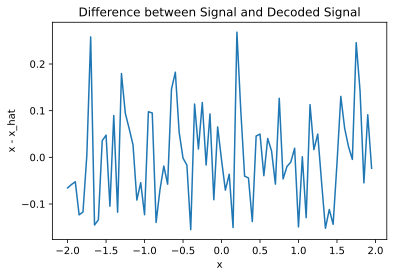

In [3]:
sigma = 0.1
A_noise = A + np.random.normal(scale=sigma*200, size=np.shape(A))
Decoder = LIF_neuron.decode_noise(A_noise, x, sigma)
x_hat = np.dot(A_noise, Decoder)

error = x - x_hat
plt.plot(x, error)
plt.title('Difference between Signal and Decoded Signal')
plt.ylabel('x - x_hat')
plt.xlabel('x')

print (f'The RMSE is: {np.sqrt(np.average(error**2))}')

# 2. Decoding from two spiking neurons

**a) Synaptic filter.** Plot the post-synaptic current
		$$
			h(t)= \begin{cases}
				0 & \text{if } t < 0 \,, \\
				\frac{e^{-t/\tau}}{\int_0^\infty e^{-t'/\tau} \mathrm{d}t'} & \text{otherwise} \,.
			\end{cases}
		$$

Text(0, 0.5, 'h(t)')

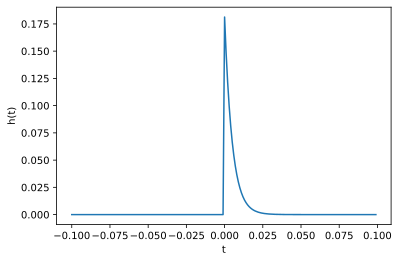

In [4]:
def _filter(n, tau):
    t_h = (np.arange(200)*dt)-0.1
    h = np.power(t_h, n)*np.exp(-t_h/tau)
    h[np.where(t_h<0)]=0
    h = h/np.linalg.norm(h,1)
    return (t_h, h)

selectNeuron = population._selected
dt = 0.001
t_h, h = _filter(n=0, tau=0.005)
plt.plot(t_h, h)
plt.xlabel('t')
plt.ylabel('h(t)')

**b) Decoding using a synaptic filter.** Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph.

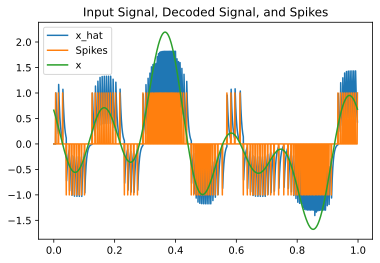

In [5]:
def rms_scaling(value, needed_rms):
    current_rms = np.sqrt(np.mean(np.square(value[np.where(value > 0)].real)))
    scaling_factor = needed_rms/current_rms
    value = np.multiply(value, scaling_factor)
    return value

def generate_signal(T, dt, rms, limit, seed=None, gaussian=False):
    if seed is None: 
        np.random.seed(None)
    else: 
        np.random.seed(seed)
    
    b = 2*np.pi*limit
    step_size = 2*np.pi/T
    w = np.arange(step_size, step_size*((T/dt)//2), step_size)
    if gaussian:
        scaling_type = np.exp((-1)*w**2/(2*b**2))    
    else:
        scaling_type = np.ones(len(w))
        scaling_type[np.where(np.abs(w)>b)] = 0

    real_parts = np.random.rand(len(w)) - 0.5
    real_parts = np.multiply(real_parts, scaling_type)
    real_parts_reversed = real_parts[::-1]
    
    imaginary_parts = np.multiply(np.random.rand(len(w))-0.5, complex(0,1))
    imaginary_parts = np.multiply(imaginary_parts, scaling_type)
    imaginary_parts_reversed = (-1)*imaginary_parts[::-1]
    
    freq_reversed = real_parts_reversed + imaginary_parts_reversed
    freq_forward = real_parts + imaginary_parts
    
    freq_signal = np.append(freq_reversed, [0])
    freq_signal = np.append(freq_signal, freq_forward)
    time_signal = np.fft.ifft(np.fft.ifftshift(freq_signal))

    time_signal = rms_scaling(time_signal, rms)
    freq_signal = rms_scaling(freq_signal, rms)

    freq_range = np.append((-1)*w[::-1], [0])
    freq_range = np.append(freq_range, w)
    t = np.arange(0, len(freq_range))*dt
    return ((t, time_signal), (freq_range, freq_signal))

dt = 0.001
time_signal, freq_signal = generate_signal(T=1, limit=5, rms=1, dt=dt)
t, x_t = time_signal
gain = selectNeuron._gain
bias = selectNeuron._bias

neuron1 = LIF_neuron(gain, bias, 1)
neuron2 = LIF_neuron(gain, bias, -1)

spikes1, voltages1 = neuron1.volt_level(x_t.real, dt)
spikes2, voltages2 = neuron2.volt_level(x_t.real, dt)

r = spikes1-spikes2

fspikes1 = np.convolve(spikes1, h, mode='same')
fspikes2 = np.convolve(spikes2, h, mode='same')
A = np.array([fspikes1, fspikes2]).transpose()

decoder = LIF_neuron.decode_noise(A, x_t)
x_hat = np.dot(A, decoder)
plt.plot(t, x_hat.real, label='x_hat')
plt.plot(t, r, label='Spikes')
plt.plot(t, x_t.real, label='x')
plt.title('Input Signal, Decoded Signal, and Spikes')
plt.legend()

**c) Error analysis.** Compute the RMSE of the decoding.

In [6]:
rmse = np.sqrt(np.mean(np.power(x_t-x_hat, 2)))
print(f'The RMSE is: {rmse.real}')

The RMSE is: 0.4085683840802486


# 3. Decoding from many neurons

**a) Exploring the error for an increasing neuron count.** Plot the Root Mean-Squared Error as the number of neurons increases, on a log-log plot. Try $8$ neurons, $16$ neurons, $32$, $64$, $128$, up to $256$. For the RMSE for a particular number of neurons, average over at least $5$ randomly generated groups of neurons. For each group of neurons, randomly generate the signal $x(t)$. Use the same parameters as in question 2.

C:\Users\nickb\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\nickb\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Error')

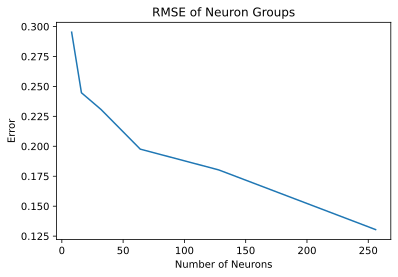

In [7]:
def neuron_groups(num_neurons):
    time_signal, freq_signal = generate_signal(T=1, limit=5, rms=1, dt=dt)
    t, x_t = time_signal

    encoders = np.random.choice([-1, 1], size=num_neurons)
    population = Population(num_neurons=num_neurons, encoders=encoders, max_rates=[100, 200], radius=radius, dx=dx)
    
    spikes, A = population.neuron_spiking(x_t, dt, h)

    decoder = LIF_neuron.decode_no_noise(A, x_t)
    x_hat = np.dot(A, decoder)

    rmse = np.sqrt(np.mean(np.power(x_t-x_hat, 2)))
    return rmse.real

test_values = [8, 16, 32, 64, 128, 256]
errors = np.zeros(np.size(test_values))
for i in range(0, 5):
    errors = [sum(x) for x in zip(errors, [neuron_groups(j) for j in test_values])]

errors = [err / 5 for err in errors]

plt.plot(test_values, errors)
plt.title('RMSE of Neuron Groups')
plt.xlabel('Number of Neurons')
plt.ylabel('Error')

**b) Discussion.** Discuss your results. What is the systematic relationship between the neuron count and the error?

The systematic relationship between neuron count and error is that increasing neuron count decreases error. This relationship is logarithmic, with further increasing of neuron count causing smaller and smaller decreases in error.

# 4. Connecting two groups of neurons

**a) Computing a function.** Show the behaviour of the system with an input of $x(t)=t-1$ for $1\,\mathrm{s}$ (a linear ramp from $-1$ to $0$). Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.

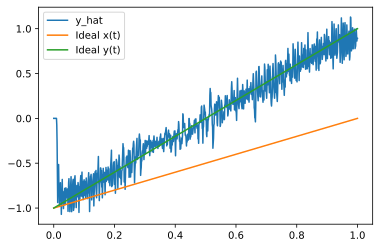

In [8]:
def q4(x, x_t, dt):
    num_neurons = 200
    
    encoders = np.random.choice([-1, 1], size=num_neurons)
    population_1 = Population(num_neurons=num_neurons, encoders=encoders, max_rates=[100, 200], 
                            radius=1, dx=dx, f=lambda t: 2*t+1)
    spikes_1, A_1 = population_1.neuron_spiking(x_t, dt, h)
    decoder_1 = LIF_neuron.decode_no_noise(A_1, x_t, f=lambda t: 2*t+1)
    x_hat = np.dot(A_1, decoder_1)

    encoders = np.random.choice([-1, 1], size=num_neurons)
    population_2 = Population(num_neurons=num_neurons, encoders=encoders, max_rates=[100, 200],
                              radius=1, dx=dx, f=lambda t: t)
    spikes_2, A_2 = population.neuron_spiking(x_hat, dt, h)
    decoder_2 = LIF_neuron.decode_no_noise(A_2, x_hat)
    y_hat = np.dot(A_2, decoder_2)
    
    plt.figure()
    plt.plot(x, y_hat, label='y_hat')
    plt.plot(x, x_t, label='Ideal x(t)')
    plt.plot(x, 2*x_t+1, label='Ideal y(t)')
    plt.legend()

x = np.arange(0, 1+dt, dt)
x_t = x - 1
q4(x, x_t, dt)

**b) Step input.** Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)

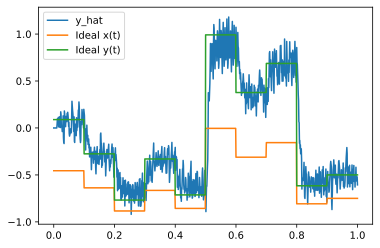

In [9]:
x = np.arange(0, 1+dt, dt)
x_t = np.arange(0, 1+dt, dt)
steps = 0
for i in range(0, int(1000)+1):
    if i >= 100*(steps) and i != 1000:
        rand_value = -1*np.random.random_sample()
        steps += 1
    x_t[i] = rand_value
    
q4(x, x_t, dt)

**c) Sinusoidal input.** Repeat part (a) with an input that is $x(t)=0.2\sin(6\pi t)$.

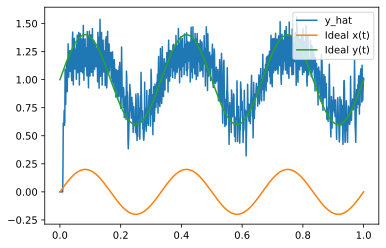

In [10]:
x = np.arange(0, 1+dt, dt)
x_t = 0.2*np.sin(6*np.pi*x)
q4(x, x_t, dt)

**d) Discussion.** Briefly discuss the results for this question. Does the output match the ideal output? What kind of deviations do you see and why do those exist?

The output of the second group of neurons (y_hat) generally matches the shape of the ideal y(t), however there is a large amount of deviations due to noise. These deviations are larger for the output of the second group of neurons (y_hat) than the first group of neurons (x_hat) due to the second group of neurons being decoded from the decoding of group 1. This means that any noise as a result of the decoding of the first output is compounded through the second decoding, causing these large deviations.

# 5. Connecting three groups of neurons

**a) Sinusoidal input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=\cos(3\pi t)$ and $y(t)=0.5 \sin (2 \pi t)$ (over $1\,\mathrm{s}$).

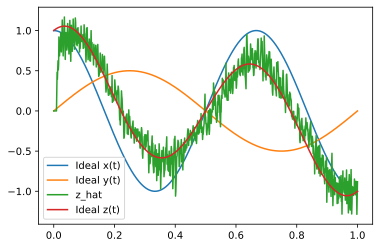

In [11]:
def q5(x, x_t, y_t, dt):
    num_neurons = 200
    
    encoders = np.random.choice([-1, 1], size=num_neurons)
    population_1 = Population(num_neurons=num_neurons, encoders=encoders, max_rates=[100, 200], 
                            radius=1, dx=dx, f=lambda t: t)
    spikes_1, A_1 = population_1.neuron_spiking(x_t, dt, h)
    decoder_1 = LIF_neuron.decode_no_noise(A_1, x_t, f=lambda t: t)
    x_hat = np.dot(A_1, decoder_1)

    encoders = np.random.choice([-1, 1], size=num_neurons)
    population_2 = Population(num_neurons=num_neurons, encoders=encoders, max_rates=[100, 200],
                              radius=1, dx=dx, f=lambda t: t)
    spikes_2, A_2 = population.neuron_spiking(y_t, dt, h)
    decoder_2 = LIF_neuron.decode_no_noise(A_2, y_t, f=lambda t: t)
    y_hat = np.dot(A_2, decoder_2)
    
    z_ideal = np.add(x_t, y_t)
    z_t = np.add(x_hat, y_hat)
    encoders = np.random.choice([-1, 1], size=num_neurons)
    population_3 = Population(num_neurons=num_neurons, encoders=encoders, max_rates=[100, 200],
                              radius=1, dx=dx, f=lambda t: t)
    spikes_3, A_3 = population.neuron_spiking(z_t, dt, h)
    decoder_3 = LIF_neuron.decode_no_noise(A_3, z_t, f=lambda t: t)
    z_hat = np.dot(A_3, decoder_3)
    
    
    plt.figure()
#     plt.plot(x, y_hat, label='y_hat')
#     plt.plot(x, x_hat, label='x_hat')
    plt.plot(x, x_t, label='Ideal x(t)')
    plt.plot(x, y_t, label='Ideal y(t)')
    plt.plot(x, z_hat, label='z_hat')
    plt.plot(x, z_ideal, label='Ideal z(t)')
    plt.legend()

x = np.arange(0, 1+dt, dt)
x_t = np.cos(3*np.pi*x)
y_t = 0.5*np.sin(2*np.pi*x)
q5(x, x_t, y_t, dt)

**b) Random input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over $1\,\mathrm{s}$. For $x(t)$ use a random signal with a limit of $8\,\mathrm{Hz}$ and $\mathtt{rms}=1$. For $y(t)$ use a random signal with a limit of $5\,\mathrm{Hz}$ and $\mathtt{rms}=0.5$.

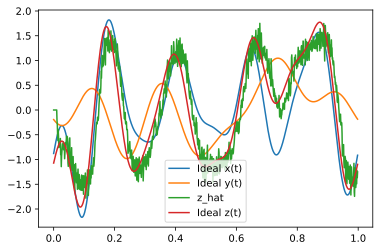

In [12]:
time_signal, freq_signal = generate_signal(T=1, limit=8, rms=1, dt=dt)
x, x_t = time_signal
time_signal, freq_signal = generate_signal(T=1, limit=5, rms=0.5, dt=dt)
x, y_t = time_signal  # just overwrite x here as is consistent between both time signals

q5(x, x_t.real, y_t.real, dt)

# 6. Computing with vectors

**a) Constant inputs.** Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for
		$$x =(0.5,1), \quad y = (0.1,0.3), \quad z =(0.2,0.1), \quad q = (0.4,-0.2) \,.$$

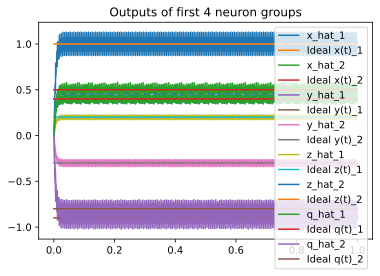

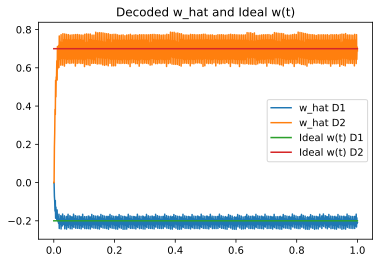

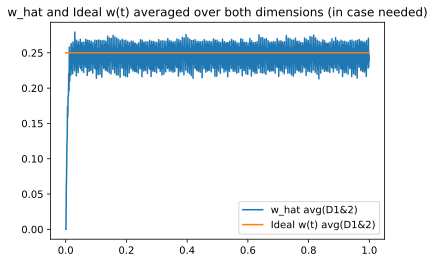

In [13]:
# sorry for not well grouping code into functions here, had a lot 
# of trouble getting matrix sizes to work and ran out of time

class LIF_neuron_2D:
    def __init__(self, gain, bias, e, tRef=0.002, tRC=0.02):
        self._gain = gain
        self._bias = bias
        self._e = e
        self._tRef = tRef
        self._tRC = tRC
    
    def current_level(self, x):
        x = np.array(x.real, float)
        gain_X = (self._gain)*x
        calculated = np.dot(gain_X, np.array(self._e))
        output = calculated + self._bias
        return output

    def volt_level(self, x, step, dimensions, init_cond=0):
        x_dim = (len(x[0]))
        spikes = np.zeros(shape=(dimensions, len(x[0])))
        volts = np.zeros(shape=(dimensions, len(x[0])))
        volts[0, 0] = init_cond
        refractory_period = int(self._tRef//step)
        for i in range(0,dimensions):
            for j in range(0, len(x[0])-1):
                if volts[i, j] < 0:
                    volts[i, j] = 0
                if volts[i, j] >= 1:
                    lower = j+1
                    upper = lower + refractory_period - 1
                    volts[i, lower:upper] = [0] * (upper-lower)
                    spikes[i, j] = 1
                    j = upper
                else:
                    J = self.current_level(x[i, j])
                    v_change = step*(1./self._tRC)*(J - volts[i, j])
                    volts[i, j+1] = volts[i, j] + v_change
        return (spikes, volts)

    def decode_no_noise(A, X, f=lambda t: t):
        dimensions = 2
        num_neurons = 200
        X = f(X)
        
        # for dimension 1
        A_temp = np.delete(A, 1, 1)
        A_temp = np.squeeze(A_temp)
        X_temp = np.delete(X.transpose(), 0, 1)
        X_temp = np.squeeze(X_temp)
        output_dim1 = np.dot(np.linalg.pinv(np.dot(A_temp, A_temp.transpose())), np.dot(A_temp, X_temp))
        # for dimension 2
        A_temp = np.delete(A, 0, 1)
        A_temp = np.squeeze(A_temp)
        X_temp = np.delete(X.transpose(), 1, 1)
        X_temp = np.squeeze(X_temp)
        output_dim2 = np.dot(np.linalg.pinv(np.dot(A_temp, A_temp.transpose())), np.dot(A_temp, X_temp))
        
        return output_dim1, output_dim2

class Population_2D:
    def __init__(self, num_neurons, encoders, max_rates=[100, 200], radius=1, dx=0.05, f=lambda t: t):
        dx = dx/radius
        intercepts = np.array([np.random.uniform(-1, 1, num_neurons), np.random.uniform(-1, 1, num_neurons)])
        max_rates = np.array([np.random.uniform(max_rates[0], max_rates[1], num_neurons), 
                              np.random.uniform(max_rates[0], max_rates[1], num_neurons)])

        slopes = max_rates / (radius*encoders - intercepts)
        biases = -1*slopes*intercepts
        gains = abs(slopes)
        
        # setting as variables for later access
        self._num_neurons = num_neurons
        self._gains = gains
        self._biases = biases
        self._encoders = encoders
        self._function = f

    def neuron_spiking(self, x_t, dt, h, dimensions=2):
        x_t = self._function(x_t)
        spikes = np.zeros(shape=(self._num_neurons, dimensions, int(np.size(x_t)/2)))
        activity = np.zeros(shape=(self._num_neurons, dimensions, int(np.size(x_t)/2)))
        for i in range(0, self._num_neurons):
            for j in range(0, dimensions):
                neuron = LIF_neuron_2D(self._gains[j, i], self._biases[j, i], self._encoders[j, i])
                neuralSpikes, voltages = neuron.volt_level(x_t, dt, dimensions)
                spikes[i, :, :] = neuralSpikes*self._encoders[j, i]
                activity[i, j, :] = np.convolve(neuralSpikes[j, :], h, mode='same')
        return spikes, activity


def q6(x, x_t, y_t, z_t, q_t, dt):
    num_neurons = 200
    angles = np.random.uniform(0, 2*np.pi, num_neurons)
    
    # decoding for x
    encoders = np.array([np.cos(angles), np.sin(angles)])  # 2 dimensions with 200 elements in each (2, 200)
    population_1 = Population_2D(num_neurons=num_neurons, encoders=encoders, max_rates=[100, 200], 
                            radius=1, dx=dx, f=lambda t: t)
    spikes_x, A_x = population_1.neuron_spiking(x_t, dt, h)
    decoder_x1, decoder_x2 = LIF_neuron_2D.decode_no_noise(A_x, x_t, f=lambda t: t)
    A_temp = np.squeeze(np.delete(A_x, 1, 1))
    x_hat_1 = np.dot(A_temp.transpose(), decoder_x1)
    A_temp = np.squeeze(np.delete(A_x, 0, 1))
    x_hat_2 = np.dot(A_temp.transpose(), decoder_x2)
    # dimension 1 and 2 values for x_t
    X_1 = np.squeeze(np.delete(x_t.transpose(), 0, 1))
    X_2 = np.squeeze(np.delete(x_t.transpose(), 1, 1))
    
    # decoding for y
    encoders = np.array([np.cos(angles), np.sin(angles)])
    population_2 = Population_2D(num_neurons=num_neurons, encoders=encoders, max_rates=[100, 200],
                              radius=1, dx=dx, f=lambda t: t)
    spikes_y, A_y = population_2.neuron_spiking(y_t, dt, h)
    decoder_y1, decoder_y2 = LIF_neuron_2D.decode_no_noise(A_y, y_t, f=lambda t: t)
    A_temp = np.squeeze(np.delete(A_y, 1, 1))
    y_hat_1 = np.dot(A_temp.transpose(), decoder_y1)
    A_temp = np.squeeze(np.delete(A_y, 0, 1))
    y_hat_2 = np.dot(A_temp.transpose(), decoder_y2)
    # dimension 1 and 2 values for y_t
    Y_1 = np.squeeze(np.delete(y_t.transpose(), 0, 1))
    Y_2 = np.squeeze(np.delete(y_t.transpose(), 1, 1))
    
    # decoding for z
    encoders = np.array([np.cos(angles), np.sin(angles)])
    population_3 = Population_2D(num_neurons=num_neurons, encoders=encoders, max_rates=[100, 200],
                              radius=1, dx=dx, f=lambda t: t)
    spikes_z, A_z = population_3.neuron_spiking(z_t, dt, h)
    decoder_z1, decoder_z2 = LIF_neuron_2D.decode_no_noise(A_z, z_t, f=lambda t: t)
    A_temp = np.squeeze(np.delete(A_z, 1, 1))
    z_hat_1 = np.dot(A_temp.transpose(), decoder_z1)
    A_temp = np.squeeze(np.delete(A_z, 0, 1))
    z_hat_2 = np.dot(A_temp.transpose(), decoder_z2)
    # dimension 1 and 2 values for z_t
    Z_1 = np.squeeze(np.delete(z_t.transpose(), 0, 1))
    Z_2 = np.squeeze(np.delete(z_t.transpose(), 1, 1))
    
    # decoding for Q
    encoders = np.array([np.cos(angles), np.sin(angles)])
    population_4 = Population_2D(num_neurons=num_neurons, encoders=encoders, max_rates=[100, 200],
                              radius=1, dx=dx, f=lambda t: t)
    spikes_q, A_q = population_4.neuron_spiking(q_t, dt, h)
    decoder_q1, decoder_q2 = LIF_neuron_2D.decode_no_noise(A_q, q_t, f=lambda t: t)
    A_temp = np.squeeze(np.delete(A_q, 1, 1))
    q_hat_1 = np.dot(A_temp.transpose(), decoder_q1)
    A_temp = np.squeeze(np.delete(A_q, 0, 1))
    q_hat_2 = np.dot(A_temp.transpose(), decoder_q2)
    # dimension 1 and 2 values for q_t
    Q_1 = np.squeeze(np.delete(q_t.transpose(), 0, 1))
    Q_2 = np.squeeze(np.delete(q_t.transpose(), 1, 1))
    
    # decoding for W
    w_t_1 = np.add(np.add(x_hat_1, y_hat_1), np.add(z_hat_1, q_hat_1))
    w_t_2 = np.add(np.add(x_hat_2, y_hat_2), np.add(z_hat_2, q_hat_2))
    w_t = np.array([w_t_1, w_t_2])
    encoders = np.array([np.cos(angles), np.sin(angles)])
    population_5 = Population_2D(num_neurons=num_neurons, encoders=encoders, max_rates=[100, 200],
                              radius=1, dx=dx, f=lambda t: t)
    spikes_w, A_w = population_5.neuron_spiking(w_t, dt, h)
    decoder_w1, decoder_w2 = LIF_neuron_2D.decode_no_noise(A_w, w_t, f=lambda t: t)
    A_temp = np.squeeze(np.delete(A_w, 1, 1))
    w_hat_1 = np.dot(A_temp.transpose(), decoder_w1)
    A_temp = np.squeeze(np.delete(A_w, 0, 1))
    w_hat_2 = np.dot(A_temp.transpose(), decoder_w2)
    # dimensions 1 and 2 for values w_t
    W_1 = np.add(np.add(X_1, Y_1), np.add(Z_1, Q_1))
    W_2 = np.add(np.add(X_2, Y_2), np.add(Z_2, Q_2))
    
    # Plotting the outputs of first 4 neuron groups
    x_graph = np.squeeze(np.delete(x.transpose(), 0, 1))
    plt.figure()
    plt.plot(x_graph, x_hat_1, label='x_hat_1')
    plt.plot(x_graph, X_1, label='Ideal x(t)_1')
    plt.plot(x_graph, x_hat_2, label='x_hat_2')
    plt.plot(x_graph, X_2, label='Ideal x(t)_2')
    plt.plot(x_graph, y_hat_1, label='y_hat_1')
    plt.plot(x_graph, Y_1, label='Ideal y(t)_1')
    plt.plot(x_graph, y_hat_2, label='y_hat_2')
    plt.plot(x_graph, Y_2, label='Ideal y(t)_2')
    plt.plot(x_graph, z_hat_1, label='z_hat_1')
    plt.plot(x_graph, Z_1, label='Ideal z(t)_1')
    plt.plot(x_graph, z_hat_2, label='z_hat_2')
    plt.plot(x_graph, Z_2, label='Ideal z(t)_2')
    plt.plot(x_graph, q_hat_1, label='q_hat_1')
    plt.plot(x_graph, Q_1, label='Ideal q(t)_1')
    plt.plot(x_graph, q_hat_2, label='q_hat_2')
    plt.plot(x_graph, Q_2, label='Ideal q(t)_2')
    plt.title('Outputs of first 4 neuron groups')
    plt.legend()
    
    plt.figure()
    plt.plot(x_graph, w_hat_1, label='w_hat D1')
    plt.plot(x_graph, w_hat_2, label='w_hat D2')
    plt.plot(x_graph, W_2, label='Ideal w(t) D1')
    plt.plot(x_graph, W_1, label='Ideal w(t) D2')
    plt.title('Decoded w_hat and Ideal w(t)')
    plt.legend()
    
    plt.figure()
    plt.plot(x_graph, (w_hat_1 + w_hat_2)/2, label='w_hat avg(D1&2)')
    plt.plot(x_graph, (W_1 + W_2)/2, label='Ideal w(t) avg(D1&2)')
    plt.title('w_hat and Ideal w(t) averaged over both dimensions (in case needed)')
    plt.legend()

ns = int(1/dt)
x_range = np.linspace(0, 1, ns)
x = np.array([x_range, x_range])
x_t = np.array([np.ones(ns)*0.5, np.ones(ns)])
y_t = -3*np.array([np.ones(ns)*0.1, np.ones(ns)*0.3])
z_t = 2*np.array([np.ones(ns)*0.2, np.ones(ns)*0.1])
q_t = -2*np.array([np.ones(ns)*0.4, np.ones(ns)*(-0.2)])

q6(x, x_t, y_t, z_t, q_t, dt)

**b) Sinusoidal input.** Produce the same plot for
$$x =(0.5,1), \quad y = (\sin(4\pi t),0.3), \quad z =(0.2,0.1), \quad q = (\sin(4\pi t),-0.2) \,.$$

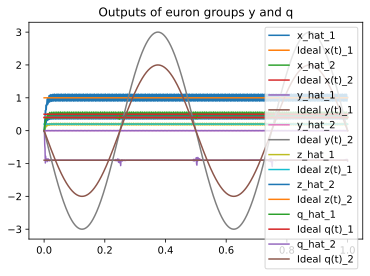

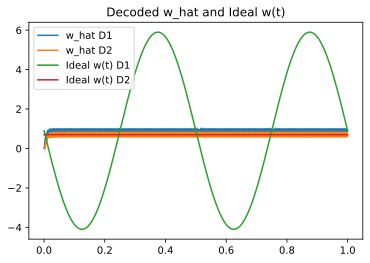

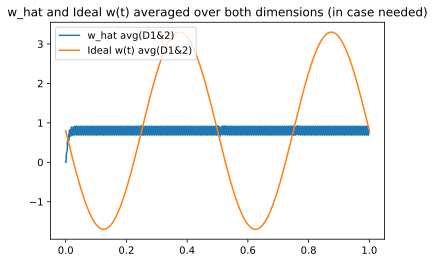

In [14]:
def q6b(x, x_t, y_t, z_t, q_t, dt):
    num_neurons = 200
    angles = np.random.uniform(0, 2*np.pi, num_neurons)
    
    # decoding for x
    encoders = np.array([np.cos(angles), np.sin(angles)])  # 2 dimensions with 200 elements in each (2, 200)
    population_1 = Population_2D(num_neurons=num_neurons, encoders=encoders, max_rates=[100, 200], 
                            radius=1, dx=dx, f=lambda t: t)
    spikes_x, A_x = population_1.neuron_spiking(x_t, dt, h)
    decoder_x1, decoder_x2 = LIF_neuron_2D.decode_no_noise(A_x, x_t, f=lambda t: t)
    A_temp = np.squeeze(np.delete(A_x, 1, 1))
    x_hat_1 = np.dot(A_temp.transpose(), decoder_x1)
    A_temp = np.squeeze(np.delete(A_x, 0, 1))
    x_hat_2 = np.dot(A_temp.transpose(), decoder_x2)
    # dimension 1 and 2 values for x_t
    X_1 = np.squeeze(np.delete(x_t.transpose(), 0, 1))
    X_2 = np.squeeze(np.delete(x_t.transpose(), 1, 1))
    
    # decoding for y
    encoders = np.array([np.cos(angles), np.sin(angles)])
    population_2 = Population_2D(num_neurons=num_neurons, encoders=encoders, max_rates=[100, 200],
                              radius=1, dx=dx, f=lambda t: t)
    spikes_y, A_y = population_2.neuron_spiking(y_t, dt, h)
    decoder_y1, decoder_y2 = LIF_neuron_2D.decode_no_noise(A_y, y_t, f=lambda t: t)
    A_temp = np.squeeze(np.delete(A_y, 1, 1))
    y_hat_1 = np.dot(A_temp.transpose(), decoder_y1)
    A_temp = np.squeeze(np.delete(A_y, 0, 1))
    y_hat_2 = np.dot(A_temp.transpose(), decoder_y2)
    # dimension 1 and 2 values for y_t
    Y_1 = np.squeeze(np.delete(y_t.transpose(), 0, 1))
    Y_2 = np.squeeze(np.delete(y_t.transpose(), 1, 1))
    
    # decoding for z
    encoders = np.array([np.cos(angles), np.sin(angles)])
    population_3 = Population_2D(num_neurons=num_neurons, encoders=encoders, max_rates=[100, 200],
                              radius=1, dx=dx, f=lambda t: t)
    spikes_z, A_z = population_3.neuron_spiking(z_t, dt, h)
    decoder_z1, decoder_z2 = LIF_neuron_2D.decode_no_noise(A_z, z_t, f=lambda t: t)
    A_temp = np.squeeze(np.delete(A_z, 1, 1))
    z_hat_1 = np.dot(A_temp.transpose(), decoder_z1)
    A_temp = np.squeeze(np.delete(A_z, 0, 1))
    z_hat_2 = np.dot(A_temp.transpose(), decoder_z2)
    # dimension 1 and 2 values for z_t
    Z_1 = np.squeeze(np.delete(z_t.transpose(), 0, 1))
    Z_2 = np.squeeze(np.delete(z_t.transpose(), 1, 1))
    
    # decoding for Q
    encoders = np.array([np.cos(angles), np.sin(angles)])
    population_4 = Population_2D(num_neurons=num_neurons, encoders=encoders, max_rates=[100, 200],
                              radius=1, dx=dx, f=lambda t: t)
    spikes_q, A_q = population_4.neuron_spiking(q_t, dt, h)
    decoder_q1, decoder_q2 = LIF_neuron_2D.decode_no_noise(A_q, q_t, f=lambda t: t)
    A_temp = np.squeeze(np.delete(A_q, 1, 1))
    q_hat_1 = np.dot(A_temp.transpose(), decoder_q1)
    A_temp = np.squeeze(np.delete(A_q, 0, 1))
    q_hat_2 = np.dot(A_temp.transpose(), decoder_q2)
    # dimension 1 and 2 values for q_t
    Q_1 = np.squeeze(np.delete(q_t.transpose(), 0, 1))
    Q_2 = np.squeeze(np.delete(q_t.transpose(), 1, 1))
    
    # decoding for W
    w_t_1 = np.add(np.add(x_hat_1, y_hat_1), np.add(z_hat_1, q_hat_1))
    w_t_2 = np.add(np.add(x_hat_2, y_hat_2), np.add(z_hat_2, q_hat_2))
    w_t = np.array([w_t_1, w_t_2])
    encoders = np.array([np.cos(angles), np.sin(angles)])
    population_5 = Population_2D(num_neurons=num_neurons, encoders=encoders, max_rates=[100, 200],
                              radius=1, dx=dx, f=lambda t: t)
    spikes_w, A_w = population_5.neuron_spiking(w_t, dt, h)
    decoder_w1, decoder_w2 = LIF_neuron_2D.decode_no_noise(A_w, w_t, f=lambda t: t)
    A_temp = np.squeeze(np.delete(A_w, 1, 1))
    w_hat_1 = np.dot(A_temp.transpose(), decoder_w1)
    A_temp = np.squeeze(np.delete(A_w, 0, 1))
    w_hat_2 = np.dot(A_temp.transpose(), decoder_w2)
    # dimensions 1 and 2 for values w_t
    W_1 = np.add(np.add(X_1, Y_1), np.add(Z_1, Q_1))
    W_2 = np.add(np.add(X_2, Y_2), np.add(Z_2, Q_2))
    
    # Plotting the outputs of first 4 neuron groups
    x_graph = np.squeeze(np.delete(x.transpose(), 0, 1))
    plt.figure()
    plt.plot(x_graph, x_hat_1, label='x_hat_1')
    plt.plot(x_graph, X_1, label='Ideal x(t)_1')
    plt.plot(x_graph, x_hat_2, label='x_hat_2')
    plt.plot(x_graph, X_2, label='Ideal x(t)_2')
    plt.plot(x_graph, y_hat_1, label='y_hat_1')
    plt.plot(x_graph, Y_1, label='Ideal y(t)_1')
    plt.plot(x_graph, y_hat_2, label='y_hat_2')
    plt.plot(x_graph, Y_2, label='Ideal y(t)_2')
    plt.plot(x_graph, z_hat_1, label='z_hat_1')
    plt.plot(x_graph, Z_1, label='Ideal z(t)_1')
    plt.plot(x_graph, z_hat_2, label='z_hat_2')
    plt.plot(x_graph, Z_2, label='Ideal z(t)_2')
    plt.plot(x_graph, q_hat_1, label='q_hat_1')
    plt.plot(x_graph, Q_1, label='Ideal q(t)_1')
    plt.plot(x_graph, q_hat_2, label='q_hat_2')
    plt.plot(x_graph, Q_2, label='Ideal q(t)_2')
    plt.title('Outputs of euron groups y and q')
    plt.legend()
    
    plt.figure()
    plt.plot(x_graph, w_hat_1, label='w_hat D1')
    plt.plot(x_graph, w_hat_2, label='w_hat D2')
    plt.plot(x_graph, W_2, label='Ideal w(t) D1')
    plt.plot(x_graph, W_1, label='Ideal w(t) D2')
    plt.title('Decoded w_hat and Ideal w(t)')
    plt.legend()
    
    plt.figure()
    plt.plot(x_graph, (w_hat_1 + w_hat_2)/2, label='w_hat avg(D1&2)')
    plt.plot(x_graph, (W_1 + W_2)/2, label='Ideal w(t) avg(D1&2)')
    plt.title('w_hat and Ideal w(t) averaged over both dimensions (in case needed)')
    plt.legend()

ns = int(1/dt)
x_range = np.linspace(0, 1, ns)
x = np.array([x_range, x_range])
x_t = np.array([np.ones(ns)*0.5, np.ones(ns)])
y_t = -3*np.array([np.sin(4*np.pi*x_range), np.ones(ns)*0.3])
z_t = 2*np.array([np.ones(ns)*0.2, np.ones(ns)*0.1])
q_t = -2*np.array([np.sin(4*np.pi*x_range), np.ones(ns)*(-0.2)])

q6b(x, x_t, y_t, z_t, q_t, dt)

**c) Discussion.** Describe your results and discuss why and how they stray from the expected answer.

My results for part 6.a) are similar to the outputs from questions 4 and 5, and do not stray too far from the expected. There is  noise for the linear decodings, but the noise range for w_hat is similar to the previous neurons groups as the noises are all random within similar ranges and added together, somewhat averaging the noise. The results from part 6.b), however, stray significantly from the expected answer when modelling sine functions, and as a result the w_hat also deviates significantly from the expected answer. When modelling sine functions, the neurons are outputting the average value for the sine function instead of following the sine wave, causing the outputted w_hat to also follow this behaviour and stray from the expected answer.